[Index](Index.ipynb) - [Back](Widget Styling.ipynb)

In [1]:
from __future__ import print_function

# Building a Custom Widget - Hello World

The widget framework is built on top of the Comm framework (short for communication).  The Comm framework is a framework that allows the kernel to send/receive JSON messages to/from the front end (as seen below).

![Widget layer](images/WidgetArch.png)

To create a custom widget, you need to define the widget both in the browser and in the python kernel.

## Building a Custom Widget

To get started, you'll create a simple hello world widget.  Later you'll build on this foundation to make more complex widgets.

## Python Kernel

### DOMWidget and Widget

To define a widget, you must inherit from the Widget or DOMWidget base class.  If you intend for your widget to be displayed in the Jupyter notebook, you'll want to inherit from the DOMWidget.  The DOMWidget class itself inherits from the Widget class.  The Widget class is useful for cases in which the Widget is not meant to be displayed directly in the notebook, but instead as a child of another rendering environment.  For example, if you wanted to create a three.js widget (a popular WebGL library), you would implement the rendering window as a DOMWidget and any 3D objects or lights meant to be rendered in that window as Widgets.

### _view_name

Inheriting from the DOMWidget does not tell the widget framework what front end widget to associate with your back end widget.

Instead, you must tell it yourself by defining specially named trait attributes, `_view_name` and `_view_module` (as seen below) and optionally `_model_name` and `_model_module`.

In [2]:
import ipywidgets as widgets
from traitlets import Unicode, validate


class HelloWidget(widgets.DOMWidget):
    _view_name = Unicode('HelloView').tag(sync=True)
    _view_module = Unicode('hello').tag(sync=True)

### sync=True traitlets

Traitlets is an IPython library for defining type-safe properties on configurable objects.  For this tutorial you do not need to worry about the *configurable* piece of the traitlets machinery.   The `sync=True` keyword argument tells the widget framework to handle synchronizing that value to the browser.  Without `sync=True`, the browser would have no knowledge of `_view_name` or `_view_module`.

### Other traitlet types

Unicode, used for _view_name, is not the only Traitlet type, there are many more some of which are listed below:  

- Any
- Bool
- Bytes
- CBool
- CBytes
- CComplex
- CFloat
- CInt
- CLong
- CRegExp
- CUnicode
- CaselessStrEnum
- Complex
- Dict
- DottedObjectName
- Enum
- Float
- FunctionType
- Instance
- InstanceType
- Int
- List
- Long
- Set
- TCPAddress
- Tuple
- Type
- Unicode
- Union


Not all of these traitlets can be synchronized across the network, only the JSON-able traits and Widget instances will be synchronized.

## Front end (JavaScript)

### Models and views

The IPython widget framework front end relies heavily on [Backbone.js](http://backbonejs.org/).  Backbone.js is an MVC (model view controller) framework.  Widgets defined in the back end are automatically synchronized with generic Backbone.js models in the front end.  The traitlets are added to the front end instance automatically on first state push.  The `_view_name` trait that you defined earlier is used by the widget framework to create the corresponding Backbone.js view and link that view to the model.

### Import jupyter-js-widgets

You first need to import the `jupyter-js-widgets` module. To import modules, use the `define` method of [require.js](http://requirejs.org/) (as seen below).

In [3]:
%%javascript
define('hello', ["jupyter-js-widgets"], function(widgets) {
    
});

<IPython.core.display.Javascript object>

### Define the view

Next define your widget view class.  Inherit from the `DOMWidgetView` by using the `.extend` method.

In [4]:
%%javascript
require.undef('hello');

define('hello', ["jupyter-js-widgets"], function(widgets) {
    
    // Define the HelloView
    var HelloView = widgets.DOMWidgetView.extend({
        
    });

    return {
        HelloView: HelloView
    }
});

<IPython.core.display.Javascript object>

### Render method

Lastly, override the base `render` method of the view to define custom rendering logic.  A handle to the widget's default DOM element can be acquired via `this.el`.  The `el` property is the DOM element associated with the view.

In [5]:
%%javascript
require.undef('hello');

define('hello', ["jupyter-js-widgets"], function(widgets) {
    
    var HelloView = widgets.DOMWidgetView.extend({
        
        // Render the view.
        render: function() { 
            this.el.textContent = 'Hello World!'; 
        },
    });
    
    return {
        HelloView: HelloView
    };
});

<IPython.core.display.Javascript object>

## Test

You should be able to display your widget just like any other widget now.

In [6]:
HelloWidget()

## Making the widget stateful

There is not much that you can do with the above example that you can't do with the IPython display framework.  To change this, you will make the widget stateful.  Instead of displaying a static "hello world" message, it will display a string set by the back end.  First you need to add a traitlet in the back end.  Use the name of `value` to stay consistent with the rest of the widget framework and to allow your widget to be used with interact.

In [7]:
class HelloWidget(widgets.DOMWidget):
    _view_name = Unicode('HelloView').tag(sync=True)
    _view_module = Unicode('hello').tag(sync=True)
    value = Unicode('Hello World!').tag(sync=True)

### Accessing the model from the view

To access the model associate with a view instance, use the `model` property of the view.  `get` and `set` methods are used to interact with the Backbone model.  `get` is trivial, however you have to be careful when using `set`.  After calling the model `set` you need call the view's `touch` method.  This associates the `set` operation with a particular view so output will be routed to the correct cell.  The model also has an `on` method which allows you to listen to events triggered by the model (like value changes).

### Rendering model contents

By replacing the string literal with a call to `model.get`, the view will now display the value of the back end upon display.  However, it will not update itself to a new value when the value changes.

In [8]:
%%javascript
require.undef('hello');

define('hello', ["jupyter-js-widgets"], function(widgets) {
    
    var HelloView = widgets.DOMWidgetView.extend({
        
        render: function() { 
            this.el.textContent = this.model.get('value'); 
        },
    });
    
    return {
        HelloView : HelloView
    };
});

<IPython.core.display.Javascript object>

### Dynamic updates

To get the view to update itself dynamically, register a function to update the view's value when the model's `value` property changes.  This can be done using the `model.on` method.  The `on` method takes three parameters, an event name, callback handle, and callback context.   The Backbone event named `change` will fire whenever the model changes.  By appending `:value` to it, you tell Backbone to only listen to the change event of the `value` property (as seen below).

In [9]:
%%javascript
require.undef('hello');

define('hello', ["jupyter-js-widgets"], function(widgets) {
    
    var HelloView = widgets.DOMWidgetView.extend({
        
        render: function() { 
            this.value_changed();
            this.model.on('change:value', this.value_changed, this);
        },
        
        value_changed: function() {
            this.el.textContent = this.model.get('value'); 
        },
    });
    
    return {
        HelloView : HelloView
    };
});

<IPython.core.display.Javascript object>

## Test

In [10]:
w = HelloWidget()
w

In [11]:
w.value = 'test'

## Conclusion

The example above dumps the value directly into the DOM.  There is no way for you to interact with this dumped data in the front end.  To create an example that accepts input, you will have to do something more than blindly dumping the contents of value into the DOM.  

In the next section of the tutorial, you will build a date picker to display and accept input in the front end.

# Building a Custom Widget - Date Picker

In the last section we created a simple widget that displayed *Hello World!*
To make an actual date widget, we need to add a property that will be synced between the Python model and the JavaScript model.
The new attribute must be a traitlet, so the widget machinery can handle it.
The traitlet must be constructed with a `sync=True` keyword argument, to tell the widget machinery knows to synchronize it with the front-end.
Adding this to the code from the last section:

In [12]:
class DateWidget(widgets.DOMWidget):
    _view_name = Unicode('DatePickerView').tag(sync=True)
    _view_module = Unicode('datepicker').tag(sync=True)
    value = Unicode().tag(sync=True)

## JavaScript

In the JavaScript, there is no need to define counterparts to the traitlets.
When the JavaScript model is created for the first time,
it copies all of the traitlet `sync=True` attributes from the Python model.
We need to replace *Hello World!* with an actual HTML date picker widget.

In [13]:
%%javascript
requirejs.undef('datepicker');

define('datepicker', ["jupyter-js-widgets"], function(widgets) {

    var DatePickerView = widgets.DOMWidgetView.extend({
        render: function() {           
            this.date = document.createElement('input');
            this.date.setAttribute('type', 'date');
            this.el.appendChild(this.date);
        },
    });
    
    return {
        DatePickerView: DatePickerView
    };
});

<IPython.core.display.Javascript object>

In order to get the HTML date picker to update itself with the value set in the back-end, we need to implement an `update()` method.

In [14]:
%%javascript
requirejs.undef('datepicker');

define('datepicker', ["jupyter-js-widgets"], function(widgets) {
    
    var DatePickerView = widgets.DOMWidgetView.extend({
        render: function() {
            this.date = documentElement('input');
            this.date.setAttribute('type', 'date');
            this.el.appendChild(this.date);
            this.update();
        },
        
        update: function() {
            // Set the value of the date control and then call base.
            // ISO format "YYYY-MM-DDTHH:mm:ss.sssZ" is required
            this.date.value = this.model.get('value');
            return DatePickerView.__super__.update.apply(this);
        },
    });
    
    return {
        DatePickerView: DatePickerView
    };
});

<IPython.core.display.Javascript object>

To get the changed value from the frontend to publish itself to the backend,
we need to listen to the change event triggered by the HTM date control and set the value in the model.
After the date change event fires and the new value is set in the model,
it is very important that we call `this.touch()` to let the widget machinery know which view changed the model.
This is important because the widget machinery needs to know which cell to route the message callbacks to.

**Final JavaScript code below:**

In [15]:
%%javascript
requirejs.undef('datepicker');

define('datepicker', ["jupyter-js-widgets"], function(widgets) {
   
    var DatePickerView = widgets.DOMWidgetView.extend({
        render: function() {
            this.date = document.createElement('input');
            this.date.setAttribute('type', 'date');
            this.el.appendChild(this.date);      
            this.update();
        },
        
        update: function() {
            // Set the value of the date control and then call base.
            // ISO format "YYYY-MM-DDTHH:mm:ss.sssZ" is required
            this.date.value = this.model.get('value');
            return DatePickerView.__super__.update.apply(this);
        },
        
        // Tell Backbone to listen to the change event of input controls (which the HTML date picker is)
        events: {
            "change": "handle_date_change"
        },
        
        // Callback for when the date is changed.
        handle_date_change: function(event) {
            this.model.set('value', this.date.value);
            this.touch();
        },
    });
    
    return {
        DatePickerView: DatePickerView
    };
});

<IPython.core.display.Javascript object>

## Test
To test, create the widget the same way that the other widgets are created.

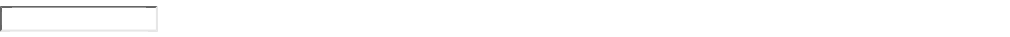

In [16]:
my_widget = DateWidget()
my_widget

Display the widget again to make sure that both views remain in sync.

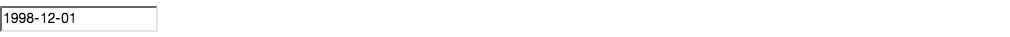

In [17]:
my_widget

Read the date from Python

In [18]:
my_widget.value

''

Set the date from Python

In [19]:
my_widget.value = "1998-12-01" # December 1st, 1998

# Building a Custom Widget - A More Advanced Date Picker

The 3rd party `dateutil` library is required to continue.  https://pypi.python.org/pypi/python-dateutil

## Import the dateutil library to parse date strings.

In [20]:
from dateutil import parser

In the last section we created a fully working date picker widget.
Now we will add custom validation and support for labels.
So far, only the ISO date format "YYYY-MM-DD" is supported.
Now, we will add support for all of the date formats recognized by the Python dateutil library.

## Python

The standard property name used for widget labels is `description`.
In the code block below, `description` has been added to the Python widget.

In [21]:
class DateWidget(widgets.DOMWidget):
    _view_name = Unicode('DatePickerView').tag(sync=True)
    _view_module = Unicode('datepicker').tag(sync=True)
    value = Unicode().tag(sync=True)
    description = Unicode().tag(sync=True)

Adding a custom validator for `value`

In [22]:
class DateWidget(widgets.DOMWidget):
    _view_name = Unicode('DatePickerView').tag(sync=True)
    _view_module = Unicode('datepicker').tag(sync=True)
    value = Unicode().tag(sync=True)
    description = Unicode().tag(sync=True)
    
    @validate('value')
    def _validate_value(self, proposal):
        value = proposal['value']
        try:
            parsed_date = parser.parse(value)
            parsed_date_string = parsed_date.strftime("%Y-%m-%d")
        except:
            parsed_date_string = ''
        return parsed_date_string

## JavaScript

Using the Javascript code from the last section,
we add a label to the date time object.
The label is a div with the `widget-hlabel` class applied to it.
`widget-hlabel` is a class provided by the widget framework that applies special styling to a div to make it look like the rest of the horizontal labels used with the built-in widgets.
Similar to the `widget-hlabel` class is the `widget-hbox-single` class.
The `widget-hbox-single` class applies special styling to widget containers that store a single line horizontal widget.

We hide the label if the description value is blank.

In [23]:
%%javascript
requirejs.undef('datepicker');

define('datepicker', ["jupyter-js-widgets"], function(widgets) {
    
    // Define the DatePickerView
    var DatePickerView = widgets.DOMWidgetView.extend({
        render: function() {
            // apply the standard widget classes so the css styles are consistent
            this.el.className = 'widget-hbox jupyter-widgets widget-width';
            
            this.label = document.createElement('div')
            this.label.className = 'widget-label';
            this.label.style.display = 'none';

            this.date = document.createElement('input');
            this.date.className = "form-control";
            this.date.setAttribute('type', 'date');
            
            this.el.appendChild(this.label);
            this.el.appendChild(this.date);
            
            this.update();
        },
        
        update: function() {
            // Set the value of the date control and then call base.
            // ISO format "YYYY-MM-DDTHH:mm:ss.sssZ" is required
            this.date.value = this.model.get('value');
            
            // Hide or show the label depending on the existance of a description.
            var description = this.model.get('description');
            if (description == undefined || description == '') {
                this.label.style.display = 'none';
            } else {
                this.label.innerText = description;
                this.label.style.display = '';
            }
            return DatePickerView.__super__.update.apply(this);
        },
        
        // Tell Backbone to listen to the change event of input controls (which the HTML date picker is)
        events: {
            "change": "handle_date_change"
        },
        
        // Callback for when the date is changed.
        handle_date_change: function(event) {
            this.model.set('value', this.date.value);
            this.touch();
        },
    });
    
    return {
        DatePickerView: DatePickerView
    };
});

<IPython.core.display.Javascript object>

## Test
To test the drawing of the label we create the widget like normal but supply the additional description property a value.

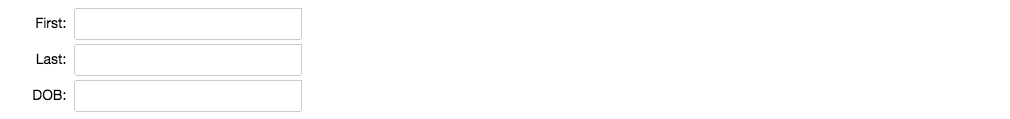

In [24]:
# Add some additional widgets for aesthetic purpose
my_widget = DateWidget()
my_widget.description="DOB:"

widgets.VBox([widgets.Text(description="First:"),
              widgets.Text(description="Last:"),
              my_widget])

## More advanced uses: Packaging and distributing Jupyter widgets

A template project is available in the form of a cookie cutter: https://github.com/jupyter/widget-cookiecutter

This project is meant to help custom widget authors get started with the packaging and the distribution of Jupyter interactive widgets.

It produces a project for a Jupyter interactive widget library following the current best practices for using interactive widgets. An implementation for a placeholder "Hello World" widget is provided.

[Index](Index.ipynb) - [Back](Widget Styling.ipynb)